In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import RobertaTokenizer, RobertaModel
from tqdm.notebook import tqdm_notebook
# from matplotlib import style
import random
import pickle
# style.use("dark_background")
seed_val = 994
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device=torch.device("cuda")

In [2]:
# %history
train_df=pd.read_csv("./MELD/data/MELD/train_sent_emo.csv")
val_df=pd.read_csv("./MELD/data/MELD/dev_sent_emo.csv")
test_df=pd.read_csv("./MELD/data/MELD/test_sent_emo.csv")


train_df.head()

# file = open("IEMOCAP_features_bert.pkl",'rb')
# object_file = pickle.load(file)
# file.close()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


/mnt/berry/home/prakhar/dgl/dgl/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

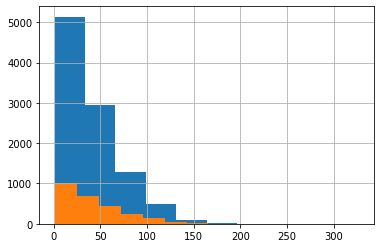

In [3]:

mapping ={'neutral':0, 'surprise':1, 'fear':2, 'sadness':3, 'joy':4, 'disgust':5, 'anger':6}

mapping2={"Chandler":0,"Phoebe":1,"Monica":2,"Ross":3,"Joey":4,"Rachel":5}

train_df=train_df.replace({"Emotion":mapping})# mapping labels to integer
val_df=val_df.replace({"Emotion":mapping})
test_df=test_df.replace({"Emotion":mapping})

train_df=train_df.replace({"Speaker":mapping2})# mapping labels to integer
val_df=val_df.replace({"Speaker":mapping2})
test_df=test_df.replace({"Speaker":mapping2})

for i,dat in train_df.iterrows():
    if isinstance(dat["Speaker"],str):
        train_df["Speaker"].iloc[i]=-1

for i,dat in test_df.iterrows():
    if isinstance(dat["Speaker"],str):
        test_df["Speaker"].iloc[i]=-1
        
for i,dat in val_df.iterrows():
    if isinstance(dat["Speaker"],str):
        val_df["Speaker"].iloc[i]=-1

train_text=train_df["Utterance"].tolist()
val_text=val_df["Utterance"].tolist()
test_text=test_df["Utterance"].tolist()


train_labels=train_df["Emotion"]
val_labels=val_df["Emotion"]
test_labels=test_df["Emotion"]

train_dia_id=train_df["Dialogue_ID"]
val_dia_id=val_df["Dialogue_ID"]
test_dia_id=test_df["Dialogue_ID"]

train_speaker=torch.tensor(train_df["Speaker"].tolist())
val_speaker=torch.tensor(val_df["Speaker"].tolist())
test_speaker=torch.tensor(test_df["Speaker"].tolist())

# print(train_text,train_labels)

len_train=[len(j) for j in train_text]
len_test=[len(i) for i in test_text]

pd.Series(len_train).hist()
pd.Series(len_test).hist()

# print(train_df.Speaker.value_counts())




In [4]:
print(train_text[6])
print(train_df["Speaker"].value_counts())

print(train_speaker)

I see.
-1    1683
 4    1510
 3    1458
 5    1435
 1    1321
 2    1299
 0    1283
Name: Speaker, dtype: int64
tensor([ 0, -1,  0,  ...,  4, -1,  4])


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
bert = RobertaModel.from_pretrained('roberta-large')

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# abc=[["u1","u2","u3"],["u1","u2","u3"],["u1","u2","u3"]]
p_w=3 #past window
# print(train_text)
train_text_list=[]
train_ids=[]
print(train_ids)
train_mask=[]
print((train_text[-1]))
print("lann")
# token_abc=tokenizer(abc)
for i,(txt,did) in enumerate(zip(train_text,train_dia_id)):
    if i<=p_w:
        train_text_list.append(train_text[:i+1])
        tokens_train=tokenizer(train_text[:i+1],
                                         max_length=80,
                                         padding=True,
                                         truncation=True)
        train_ids.append(torch.tensor(tokens_train["input_ids"]))
        train_mask.append(torch.tensor(tokens_train["attention_mask"]))
        
    else:
        train_text_list.append(train_text[i-p_w:i+1])
        tokens_train=tokenizer(train_text[i-p_w:i+1],
                                         max_length=80,
                                         padding=True,
                                         truncation=True)
        train_ids.append(torch.tensor(tokens_train["input_ids"]))
        train_mask.append(torch.tensor(tokens_train["attention_mask"]))
        
print((train_ids))
    
    

[]
That was a good one. For a second there, I was like, "whoa."
lann


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:

test_text_list=[]
test_ids=[]

test_mask=[]

for i,(txt,did) in enumerate(zip(test_text,test_dia_id)):
    if i<=p_w:
        test_text_list.append(test_text[:i+1])
        tokens_test=tokenizer(test_text[:i+1],
                                         max_length=80,
                                         padding=True,
                                         truncation=True)
        test_ids.append(torch.tensor(tokens_test["input_ids"]))
        test_mask.append(torch.tensor(tokens_test["attention_mask"]))
        
    else:
        test_text_list.append(test_text[i-p_w:i+1])
        tokens_test=tokenizer(test_text[i-p_w:i+1],
                                         max_length=80,
                                         padding=True,
                                         truncation=True)
        test_ids.append(torch.tensor(tokens_test["input_ids"]))
        test_mask.append(torch.tensor(tokens_test["attention_mask"]))
        
print((test_ids))
    

[tensor([[    0,  7608,   109,    70,    47,    17,    27,   241,  3895,   475,
         16148,    33,  1530,    15,     5,  2576,   116,     2]]), tensor([[    0,  7608,   109,    70,    47,    17,    27,   241,  3895,   475,
         16148,    33,  1530,    15,     5,  2576,   116,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    0,  7516,     4,   280,    17,    27,    29,    98, 12811,    64,
           489,  1349,     4,   280,   169,   114,    65,    15,   106,    16,
          1716,     6,    79,    64,    28,   101,     6,    44,   711, 13841,
            17,    27,    29,   346,   974, 17516,    17,    27,     2]]), tensor([[    0,  7608,   109,    70,    47,    17,    27,   241,  3895,   475,
         16148,    33,  1530,    15,     5,  2576,   116,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1, 

In [8]:
print(tokenizer.decode(test_ids[1][0]))

<s>Why do all you’re coffee mugs have numbers on the bottom?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [9]:

val_text_list=[]
val_ids=[]

val_mask=[]
for i,(txt,did) in enumerate(zip(val_text,val_dia_id)):
    if i<=p_w:
        val_text_list.append(val_text[:i+1])
        tokens_val=tokenizer(val_text[:i+1],
                                         max_length=80,
                                         padding=True,
                                         truncation=True)
        val_ids.append(torch.tensor(tokens_val["input_ids"]))
        val_mask.append(torch.tensor(tokens_val["attention_mask"]))
        
    else:
        val_text_list.append(val_text[i-p_w:i+1])
        tokens_val=tokenizer(val_text[i-p_w:i+1],
                                         max_length=80,
                                         padding=True,
                                         truncation=True)
        val_ids.append(torch.tensor(tokens_val["input_ids"]))
        val_mask.append(torch.tensor(tokens_val["attention_mask"]))

In [10]:
# train_speaker=train_speaker.tolist()
# test_speaker=test_speaker.tolist()
print(val_ids)

[tensor([[   0, 7516,  127, 1840,    6,   37,   17,   27,   29,  685,   24,    4,
           91,   17,   27,   29, 4940,  685,   24,    4,    2]]), tensor([[   0, 7516,  127, 1840,    6,   37,   17,   27,   29,  685,   24,    4,
           91,   17,   27,   29, 4940,  685,   24,    4,    2],
        [   0, 2264,  116,    2,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1]]), tensor([[    0,  7516,   127,  1840,     6,    37,    17,    27,    29,   685,
            24,     4,    91,    17,    27,    29,  4940,   685,    24,     4,
             2,     1,     1,     1],
        [    0,  2264,   116,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1],
        [    0, 11094,   328,  1793,     6,    52,   115,   213,     7,     5,
           827,     6,   593,    84,  2349,     8,   847,   106,   160,    23,
          

In [11]:
speaker_list_train=[]
speaker_list_test=[]
speaker_list_val=[]
for i,speak in enumerate(train_speaker):
    if i<=p_w:
        speaker_list_train.append(train_speaker[:i+1])
    else:
        speaker_list_train.append(train_speaker[i-p_w:i+1])
# print(len(speaker_list[4]))        

for i,speak in enumerate(test_speaker):
    if i<=p_w:
        speaker_list_test.append(test_speaker[:i+1])
    else:
        speaker_list_test.append(test_speaker[i-p_w:i+1])
        
for i,speak in enumerate(val_speaker):
    if i<=p_w:
        speaker_list_val.append(val_speaker[:i+1])
    else:
        speaker_list_val.append(val_speaker[i-p_w:i+1])

In [12]:
# tokens_train=tokenizer(train_text,
#                                          max_length=80,
#                                          padding=True,
#                                          truncation=True)

# tokens_val=tokenizer(val_text,
#                                          max_length=80,
#                                          padding=True,
#                                          truncation=True)

# tokens_test=tokenizer(test_text,
#                                          max_length=80,
#                                          padding=True,
#                                          truncation=True)

print(len(val_text))

1109


In [13]:
# train_seq=torch.tensor(tokens_train["input_ids"])
# train_mask=torch.tensor(tokens_train["attention_mask"])
train_labels=torch.tensor(train_labels.tolist()).to(device)

# val_seq=torch.tensor(tokens_val["input_ids"])
# val_mask=torch.tensor(tokens_val["attention_mask"])
val_labels=torch.tensor(val_labels.tolist()).to(device)

# test_seq=torch.tensor(tokens_test["input_ids"])
# test_mask=torch.tensor(tokens_test["attention_mask"])
test_labels=torch.tensor(test_labels.tolist()).to(device)

In [14]:
# from torch.utils.data import DataLoader,TensorDataset,RandomSampler, SequentialSampler
# batch_size=32

# train_data=TensorDataset(train_ids,train_mask,train_label)
# train_sampler=SequentialSampler(train_data)
# train_dataloader=DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

# val_data=TensorDataset(val_seq,val_mask,val_label)
# val_sampler=SequentialSampler(val_data)
# val_dataloader=DataLoader(val_data,sampler=val_sampler,batch_size=batch_size)

# test_data=TensorDataset(test_seq,test_mask,test_label)
# print(len(test_data[0][0]))
# test_sampler=SequentialSampler(test_data)
# test_dataloader=DataLoader(test_data,sampler=test_sampler,batch_size=batch_size)
# print(len(test_dataloader))

In [15]:

print(type(train_speaker))
# modules=[bert.encoder.layer[:1]]
# for module in modules:
#     for param in module.parameters():
#         param.requires_grad=False

# for name, param in list(bert.named_parameters())[:-79]: 
#     print('I will be frozen: {}'.format(name)) 
#     param.requires_grad = False


<class 'torch.Tensor'>


In [16]:
model_rob = RobertaModel.from_pretrained('roberta-large')
model_rob=model_rob.to(device)
def roberta_emb(word):
#     print(word)
    tokens=tokenizer(word,
                     return_tensors="pt")
    tokens=tokens.to(device)
#     print(tokens)
    emb=model_rob(**tokens)
#     print(model.device)
#     print(emb.pooler_output[0].shape)
    return emb.pooler_output[0]
    
# roberta_emb("no!")    

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# train_speaker=train_speaker[1:]
def senti_word_emb(sentence_list):
    decoded=[]
    emb=[]
    loca=[]
    sentiment=[]
    sia = SentimentIntensityAnalyzer()
    
    for y,z in enumerate(sentence_list):

        max_val=0
        sentiment.clear()
        sent=tokenizer.decode(z)
#         print(sent)
        word_list=sent.split()

        
        
        for i in word_list:
            a=sia.polarity_scores(i)
        
            if max_val<abs(a["compound"]):
                max_val=abs(a["compound"])
            
            sentiment.append(abs(a["compound"]))
#         print(sentiment)
    
        if max_val>0.2:
    
            emb.append(roberta_emb(word_list[sentiment.index(max(sentiment))]).tolist())
            loca.append(y)
        
        
    return emb,loca
#     word_list=sentence.split()
# #     print(word_list)

#     for i in word_list:
#         a=sia.polarity_scores(i)
#         if max_val<abs(a["compound"]):
#             max_val=abs(a["compound"])
            
#         sentiment.append(abs(a["compound"]))
# #     print(sentiment) 
# #     print(sentiment.index(max(sentiment)))
#     if max_val>0.2:
    
#         emb=roberta_emb(word_list[sentiment.index(max(sentiment))])
# #         print(emb)
#         return emb
#     else:
#         return None
    
#     print(a)    
# print(train_ids[7])
# print(train_text[7])
# print(senti_word_emb((train_text[7]))) 
# # print((tokenizer.decode(train_ids[7][3])))
# print(senti_word_emb(tokenizer.decode(train_ids[7][3])))  
# print(torch.equal(senti_word_emb((train_text[7])),senti_word_emb(tokenizer.decode(train_ids[7][3]))))
senti_word_emb(train_ids[15])

([[0.1538991630077362,
   0.6990387439727783,
   0.42726385593414307,
   -0.6813342571258545,
   0.7148380279541016,
   -0.8823007345199585,
   -0.7232259511947632,
   -0.2550550699234009,
   -0.13615573942661285,
   0.20646382868289948,
   -0.9012773036956787,
   -0.3831064999103546,
   -0.23501797020435333,
   -0.6771948933601379,
   -0.5903666019439697,
   -0.3973999321460724,
   0.4209534525871277,
   0.3412456214427948,
   -0.7445448040962219,
   -0.7308454513549805,
   -0.6709631681442261,
   0.566565752029419,
   -0.002156093716621399,
   0.10377741605043411,
   -0.7117859125137329,
   -0.11521252989768982,
   -0.2349322885274887,
   -0.2918424904346466,
   0.793727695941925,
   -0.7912036180496216,
   0.7444596290588379,
   0.350535124540329,
   -0.05552651360630989,
   0.3417344391345978,
   -0.029569145292043686,
   -0.5825620889663696,
   -0.22719824314117432,
   0.22385002672672272,
   0.08316504955291748,
   0.2993084192276001,
   0.2563855051994324,
   0.3734108507633209,

In [18]:
import dgl
from dgl.nn import GraphConv
import graph4nlp
print([i for i in range(3)])

Using backend: pytorch[21:19:31] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /mnt/berry/home/prakhar/dgl/dgl/lib/python3.8/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.0.so: cannot open shared object file: No such file or directory



[0, 1, 2]


In [19]:
def make_graph(embed,text_ids,speakers):
    if len(embed)> (3):
        
#         u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
        u,v=[0,1,2],[1,2,3]
#         k=[0,1,2,3,4,5]

#         emb=[]
#         loca=[]
        emb,loca=senti_word_emb(text_ids)
#         for loc,txt in enumerate(text):
#             if senti_word_emb(txt)!=None:
#                 emb.append(senti_word_emb(txt).tolist())
#                 loca.append(loc)
#                 print(txt)
#         print("lcoa before pop",loca)
#         print("speakers before pop",speakers)
        speakers=speakers.tolist()

        for j,z in reversed(list(enumerate(loca))):
            if speakers[z]==-1:         
#                 print("j",j)                               #reverse before poppong for correct index
#                 remove_index.append(j)
                loca.pop(j)
                emb.pop(j)
        
#         print("loca afer pop",loca)
#         print("speakers",speakers)
        k=[]
        speaker_node=[]
        for idx in range(3+1):
#             if isinstance(speakers[idx],int):
            if speakers[idx]!=-1:
                k.append(idx)
                speaker_node.append(speakers[idx])
#         print("before k spnode",k,speaker_node)
    
        unique_speaker_nodes=set(speaker_node)
        
        
        speaker_emb=torch.zeros(len(unique_speaker_nodes),1024)
#         print("unique spaker",unique_speaker_nodes)
        
        for ix,xd in enumerate(unique_speaker_nodes):
            torch.manual_seed(xd)
            speaker_emb[ix]=torch.rand(1024)
        

        
        
#         print(speaker_emb)
        
        
        for z,l in enumerate(speaker_node):
            for ind,m in enumerate(unique_speaker_nodes):
                if l==m:
                    speaker_node[z]=4+ind   
                    
       
        unique_words=len(loca)
        if len(speaker_node)!=0:
            last_node=max(speaker_node)
        else:
            last_node=3
#         print("leastnode",last_node)
        word_nodes=[]
        if len(loca)!=0:
            for z in range(len(loca)):
                
                word_nodes.append(last_node+z+1)
        
#         print("word?nodes",word_nodes)
            
        word_to_utt=loca
        word_to_speaker=[]
        speaker_to_word=word_nodes
        
#         print("speaker_node",speaker_node)
#         print("loca",loca)
#         print("w2s",word_to_speaker)
            
#         print()
        for j,z in enumerate(loca):
            word_to_speaker.append(speaker_node[k.index(z)])
            
        in_feat=embed
        if len(unique_speaker_nodes)!=0:
                
                emb=torch.tensor(emb)
#                 print(emb.shape)
#                 k=torch.tensor(k)
#                 speaker_node=torch.tensor(speaker_node)
#                 word_nodes=torch.tensor(word_nodes)
#                 word_to_utt=torch.tensor(word_to_utt)
#                 word_to_speaker=torch.tensor(word_to_speaker)
#                 speaker_to_word=torch.tensor(speaker_to_word)
                u=u+k+word_to_utt+word_to_speaker
                v=v+speaker_node+word_nodes+speaker_to_word
#                 u=(torch.cat((u,k,word_to_utt,word_to_speaker),0))
#                 v=(torch.cat((v,speaker_node,word_nodes,speaker_to_word),0))
                embed=embed.to(device)
                speaker_emb=speaker_emb.to(device)
                emb=emb.to(device)
                in_feat=torch.cat((embed,speaker_emb,emb),0)
#         print("speaker",k)
#         print("now",u,v)
            
#         for idx,sp in enumerate(speakers):
#             if isinstance(sp,str):
#                 print(idx)
#                 k.pop(idx)
#                 speakers.pop(idx)
#         print("ag¥frt",speakers,k)
#         speakers=train_speaker[i-5:i+1]
#         print(speakers)
#         speakers=speakers.unique()
#         print(speakers)
#         main_speakers=[e for e in speakers if isinstance(e,int)]  
#         for e in main_speakers:
#             print(e)
#         print(train_embed[i-5:i+1])
#         print(i)
#         if i==16:
#             print(u,v,in_feat.shape)
#             print("loca",loca)
#             print("w2s",word_to_speaker)
#             print(speaker_node)
#             print()
        g=dgl.graph((u,v))
#         print(in_feat) 
        bg=dgl.to_bidirected(g)
        bg=bg.to(device)
        bg.ndata["emb"]=in_feat
        bg=dgl.add_self_loop(bg)
#         print(bg.ndata["emb"])
        
#         print(in_feat.shape)
        
        
        return bg, in_feat
    
    if len(embed)<=3:
#         print(len(embed))
        u,v=[k for k in range(len(embed)-1)],[k+1 for k in range(len(embed)-1)]
        speakers=speakers.tolist()
#         print("before",u,v)
#         k=[0,1,2,3,4,5]
#         speakers=train_speaker[i-3:i+1]
#         print(speakers)
#         speakers=speakers.tolist()
#         text=train_text[i-3:i+1]
#         emb=[]
#         loca=[]

        emb,loca=senti_word_emb(text_ids)
#         print("ebm loca",emb,loca)
#         for loc,txt in enumerate(text):
#             if senti_word_emb(txt)!=None:
#                 emb.append(senti_word_emb(txt).tolist())
#                 loca.append(loc)
#                 print(txt)
#         print("lcoa before pop",loca)
#         print("speakers before pop",speakers)
#         temp=loca.copy()
#         remove_index=[]
        for j,z in reversed(list(enumerate(loca))):
            if speakers[z]==-1:         
#                 print("j",j)                               #reverse before poppong for correct index
#                 remove_index.append(j)
                loca.pop(j)
                emb.pop(j)
        
#         print("loca afer pop",loca)
#         print(speakers)
        k=[]
        speaker_node=[]
        for idx in range(len(embed)):
#             if isinstance(speakers[idx],int):
            if speakers[idx]!=-1:
                k.append(idx)
                speaker_node.append(speakers[idx])
#         print("before k spnode",k,speaker_node)
    
        unique_speaker_nodes=set(speaker_node)
        
        
        speaker_emb=torch.zeros(len(unique_speaker_nodes),1024)
        print()
        
        for ix,xd in enumerate(unique_speaker_nodes):
            torch.manual_seed(xd)
            speaker_emb[ix]=torch.rand(1024)
        

        
        
#         print(speaker_emb)
        
        
        for z,l in enumerate(speaker_node):
            for ind,m in enumerate(unique_speaker_nodes):
                if l==m:
                    speaker_node[z]=len(embed)+ind   
                    
       
        unique_words=len(loca)
        if len(speaker_node)!=0:
            last_node=max(speaker_node)
        else:
            last_node=len(embed)
#         print("leastnode",last_node)
        word_nodes=[]
        if len(loca)!=0:
            for z in range(len(loca)):
                
                word_nodes.append(last_node+z+1)
        
#         print("word?nodes",word_nodes)
            
        word_to_utt=loca
        word_to_speaker=[]
        speaker_to_word=word_nodes
        
#         print("speaker_node",speaker_node)
#         print("loca",loca)
#         print("w2s",word_to_speaker)
            
#         print()
        for j,z in enumerate(loca):
            word_to_speaker.append(speaker_node[k.index(z)])
            
        in_feat=embed
#         print("unizuq speak",unique_speaker_nodes)
        if len(unique_speaker_nodes)!=0:
                
                emb=torch.tensor(emb)
#                 print(emb.shape)
#                 k=torch.tensor(k)
#                 speaker_node=torch.tensor(speaker_node)
#                 word_nodes=torch.tensor(word_nodes)
#                 word_to_utt=torch.tensor(word_to_utt)
#                 word_to_speaker=torch.tensor(word_to_speaker)
#                 speaker_to_word=torch.tensor(speaker_to_word)
                u=u+k+word_to_utt+word_to_speaker
                v=v+speaker_node+word_nodes+speaker_to_word
#                 u=(torch.cat((u,k,word_to_utt,word_to_speaker),0))
#                 v=(torch.cat((v,speaker_node,word_nodes,speaker_to_word),0))
                embed=embed.to(device)
                speaker_emb=speaker_emb.to(device)
                emb=emb.to(device)
                in_feat=torch.cat((embed,speaker_emb,emb),0)
#         print("speaker",k)
#         print("now",u,v)
            
#         for idx,sp in enumerate(speakers):
#             if isinstance(sp,str):
#                 print(idx)
#                 k.pop(idx)
#                 speakers.pop(idx)
#         print("ag¥frt",speakers,k)
#         speakers=train_speaker[i-5:i+1]
#         print(speakers)
#         speakers=speakers.unique()
#         print(speakers)
#         main_speakers=[e for e in speakers if isinstance(e,int)]  
#         for e in main_speakers:
#             print(e)
#         print(train_embed[i-5:i+1])
#         print(i)
        
        g=dgl.graph((u,v))
#         print(in_feat) 
#         print(in_feat.shape)
        bg=dgl.to_bidirected(g)
        bg=bg.to(device)
        bg.ndata["emb"]=in_feat
        bg=dgl.add_self_loop(bg)
#         print(bg.ndata["emb"])
        
        
        
        
        return bg,in_feat
    
        
    
    
    

In [20]:
k=torch.rand(4,1024)
print(speaker_list_train[4])
print(train_text_list[4])
print(train_ids[4].shape)
g,inf=make_graph(k,train_ids[4],speaker_list_train[4])

print(g.ndata)

tensor([-1,  0, -1,  0])
['You must’ve had your hands full.', 'That I did. That I did.', 'So let’s talk a little bit about your duties.', 'My duties?  All right.']
torch.Size([4, 15])
{'emb': tensor([[0.5173, 0.9564, 0.1276,  ..., 0.0234, 0.3368, 0.4662],
        [0.9719, 0.5256, 0.0332,  ..., 0.5356, 0.3404, 0.1743],
        [0.1831, 0.5265, 0.4946,  ..., 0.8261, 0.8850, 0.1543],
        [0.7982, 0.2845, 0.2262,  ..., 0.4457, 0.2156, 0.1669],
        [0.4963, 0.7682, 0.0885,  ..., 0.1876, 0.2099, 0.7210]],
       device='cuda:0')}


In [73]:
import dgl
from dgl.nn import GraphConv
import graph4nlp

class bert_GCN(nn.Module):
    def __init__(self,bert,in_f,o_f,num_lab):
        super().__init__()
        
        self.bert=bert
        
        self.conv1=GraphConv(in_f,o_f)
        
        self.conv2=GraphConv(in_f,o_f)
        
        self.fc=nn.Linear(in_f+o_f,num_lab)
        
    def forward(self,ids,mask,speaker_list):
        
        bert_out=self.bert(ids,mask)[1]
        
        graph,emb=make_graph(bert_out,ids,speaker_list)
        
        h=self.conv1(graph,emb)
        
        h=F.relu(h)
        
        h=self.conv2(graph,h)
        
        h=F.relu(h)
        
        bert_last=bert_out[len(ids)-1]
        graph_last=h[len(ids)-1]
#         print(bert_last.shape,graph_last.shape)
        
        h=self.fc(torch.cat((bert_last,graph_last),dim=0))
        
        
        return h
        
        
        

In [74]:
model=bert_GCN(bert,1024,1024,7)
model=model.to(device)
opt = torch.optim.Adam(model.parameters())

In [75]:
a=torch.rand(1,1024)
b=torch.rand(1,1024)
print((a+b).shape)
c=torch.cat((a[0],b[0]),dim=0)
d=a[0]
print(torch.equal(d,c[:1024]))

print(torch.cat((a[0],b[0]),dim=0).shape)


torch.Size([1, 1024])
True
torch.Size([2048])


In [76]:
loss_fn = nn.CrossEntropyLoss()
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def validate_gcn(model):
    model.eval()
    preds_val=[]
    loss_tot=0
    with torch.no_grad():
        for i,(ids,mask) in tqdm_notebook(enumerate(zip(val_ids,val_mask)),total=len(val_ids)):
            ids,mask=ids.to(device),mask.to(device)
#             print(type(ids))
            speaker_list=speaker_list_val[i].to(device)
            logits=model(ids,mask,speaker_list)
            logits=torch.unsqueeze(logits,0)
            label=torch.unsqueeze(val_labels[i],0)
            loss=loss_fn(logits,label)
            loss_tot+=loss.item()
            pred=logits.detach().cpu().numpy()
#             print(pred)
            pred=np.argmax(pred,axis=1)
            preds_val.append(pred)
#     loss_list_val.append(loss_tot)
    print("val score")
    accuracy=accuracy_score(val_labels.tolist(),preds_val)
    f1=f1_score(val_labels.tolist(),preds_val,average="weighted")
    print("accuracy=",accuracy,"f1=",f1)
    return loss_tot,accuracy,f1
    

In [77]:
print(model)

bert_GCN(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
validate_gcn(model)
# print(train_ids[8].shape)

  0%|          | 0/1109 [00:00<?, ?it/s]

In [ ]:
import torch.nn.functional as F
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

loss_fn = nn.CrossEntropyLoss()
loss_tot=0
best_f1=0
loss_list_val=[]
loss_list_train=[]
f1_list=[]
flag=0

for epoch in range(10):
    
    loss_tot=0
    model.train()
    print("="*30,"epoch",epoch,"="*30)
    for i,(ids,mask) in tqdm_notebook(enumerate(zip(train_ids[:1000],train_mask)),total=len(train_ids)):
        ids,mask=ids.to(device),mask.to(device)
#         print(type(ids))
        speaker_list=speaker_list_train[i].to(device)
        logits=model(ids,mask,speaker_list)
        logits=torch.unsqueeze(logits,0)
        label=torch.unsqueeze(train_labels[i],0)
        loss=loss_fn(logits,label)
#         print(loss)
        loss_tot=loss_tot+loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
#         print()
        
    print(loss_tot,epoch)
    
    loss_val,accuracy,f1=validate_gcn(model)
    if f1>best_f1:
        best_f1=f1
        flag=epoch
        torch.save(model,"best_model_end2end.pt")
    torch.save(model,"last_model_end2end.pt")
    loss_list_val.append(loss_val)
    loss_list_train.append(loss_tot)
    f1_list.append(f1)
print("best f1={} in epoch={}".format(best_f1,flag))
    
        
#         node_features=graph.ndata["emb"]
#         graph=dgl.add_self_loop(graph)
#         graph=graph.to(device)
#         node_features=node_features.to(device)
#         logits = model(graph, node_features)
        
#         logits=torch.unsqueeze(logits,0)
#         label=torch.unsqueeze(train_label[i],0)
#         print(logits.is_cuda,label.is_cuda)
#         loss=loss_fn(logits,label)
#         loss_tot+=loss.item()
#         opt.zero_grad()
#         loss.backward()
#         opt.step()
        
#     print(loss_tot,epoch)
#     loss_val,accuracy,f1=validate(model)
#     if f1>best_f1:
#         best_f1=f1
#         flag=epoch
#         torch.save(model,"best_model.pt")
#     torch.save(model,"last_model.pt")
#     loss_list_val.append(loss_val)
#     loss_list_train.append(loss_tot)
#     f1_list.append(f1)
# print("best f1={} in epoch={}".format(best_f1,flag))
    
    

# for step,batch in tqdm_notebook(enumerate(test_dataloader),total=len(test_dataloader)):        
            
#         batch=[r.to(device) for r in batch]
        
# #         print(batch)
#         print("lull")
        
#         sent_id,mask,labels=batch
# #         print(sent_id.shape,mask.shape)
                
#         preds=bert(sent_id,mask)[1]    # size  16*1024 batxh_size*encoding
#         print(preds.shape)

#         preds=preds.detach().cpu().numpy()

#         test_embed.append(preds)
        
#     for step,batch in tqdm_notebook(enumerate(val_dataloader),total=len(val_dataloader)):        
            
#         batch=[r.to(device) for r in batch]
        
#         sent_id,mask,labels=batch
                
#         preds=model(sent_id,mask)[1]    # size  16*1024 batxh_size*encoding

#         preds=preds.detach().cpu().numpy()

#         val_embed.append(preds)
        
#     for step,batch in tqdm_notebook(enumerate(train_dataloader),total=len(train_dataloader)):        
            
#         batch=[r.to(device) for r in batch]
        
#         sent_id,mask,labels=batch
                
#         preds=model(sent_id,mask)[1]    # size  16*1024 batxh_size*encoding


#         preds=preds.detach().cpu().numpy()

#         train_embed.append(preds)
        
#     train_embed=np.concatenate(train_embed,axis=0)
#     val_embed=np.concatenate(val_embed,axis=0)
#     test_embed= np.concatenate(test_embed,axis=0)

 


============================== epoch 0 ==============================


  0%|          | 0/9989 [00:00<?, ?it/s]

ebm loca [] []

ebm loca [] []

ebm loca [] []

2420.0501540503715 0


  0%|          | 0/1109 [00:00<?, ?it/s]

ebm loca [[0.17314203083515167, 0.7068064212799072, 0.44495075941085815, -0.6943562030792236, 0.6969659924507141, -0.8836230635643005, -0.7246595621109009, -0.25642305612564087, -0.1382739394903183, 0.2164461761713028, -0.9016431570053101, -0.39681732654571533, -0.2392917275428772, -0.6851484775543213, -0.5945704579353333, -0.38633671402931213, 0.4141913950443268, 0.3457659184932709, -0.7465613484382629, -0.7207016944885254, -0.6473909616470337, 0.5677691698074341, -0.004529672209173441, 0.10067692399024963, -0.7054758071899414, -0.10730572044849396, -0.24180378019809723, -0.2901824712753296, 0.7902300357818604, -0.7947880029678345, 0.7445411682128906, 0.3392493426799774, -0.06544720381498337, 0.3651842176914215, -0.03895621746778488, -0.5969769954681396, -0.20566856861114502, 0.1991572231054306, 0.06033444404602051, 0.30023813247680664, 0.24489963054656982, 0.39471879601478577, -0.0964755192399025, -0.2648954391479492, -0.6638736724853516, 0.7243657112121582, -0.4314080476760864, 0.34

val score
accuracy= 0.3769161406672678 f1= 0.27094109021101626
============================== epoch 1 ==============================


  0%|          | 0/9989 [00:00<?, ?it/s]

ebm loca [] []

ebm loca [] []

ebm loca [] []

2348.404751572758 1


  0%|          | 0/1109 [00:00<?, ?it/s]

ebm loca [[0.17314203083515167, 0.7068064212799072, 0.44495075941085815, -0.6943562030792236, 0.6969659924507141, -0.8836230635643005, -0.7246595621109009, -0.25642305612564087, -0.1382739394903183, 0.2164461761713028, -0.9016431570053101, -0.39681732654571533, -0.2392917275428772, -0.6851484775543213, -0.5945704579353333, -0.38633671402931213, 0.4141913950443268, 0.3457659184932709, -0.7465613484382629, -0.7207016944885254, -0.6473909616470337, 0.5677691698074341, -0.004529672209173441, 0.10067692399024963, -0.7054758071899414, -0.10730572044849396, -0.24180378019809723, -0.2901824712753296, 0.7902300357818604, -0.7947880029678345, 0.7445411682128906, 0.3392493426799774, -0.06544720381498337, 0.3651842176914215, -0.03895621746778488, -0.5969769954681396, -0.20566856861114502, 0.1991572231054306, 0.06033444404602051, 0.30023813247680664, 0.24489963054656982, 0.39471879601478577, -0.0964755192399025, -0.2648954391479492, -0.6638736724853516, 0.7243657112121582, -0.4314080476760864, 0.34

val score
accuracy= 0.4238052299368801 f1= 0.2522969703234118
============================== epoch 2 ==============================


  0%|          | 0/9989 [00:00<?, ?it/s]

ebm loca [] []

ebm loca [] []

ebm loca [] []

2331.1397837966215 2


  0%|          | 0/1109 [00:00<?, ?it/s]

ebm loca [[0.17314203083515167, 0.7068064212799072, 0.44495075941085815, -0.6943562030792236, 0.6969659924507141, -0.8836230635643005, -0.7246595621109009, -0.25642305612564087, -0.1382739394903183, 0.2164461761713028, -0.9016431570053101, -0.39681732654571533, -0.2392917275428772, -0.6851484775543213, -0.5945704579353333, -0.38633671402931213, 0.4141913950443268, 0.3457659184932709, -0.7465613484382629, -0.7207016944885254, -0.6473909616470337, 0.5677691698074341, -0.004529672209173441, 0.10067692399024963, -0.7054758071899414, -0.10730572044849396, -0.24180378019809723, -0.2901824712753296, 0.7902300357818604, -0.7947880029678345, 0.7445411682128906, 0.3392493426799774, -0.06544720381498337, 0.3651842176914215, -0.03895621746778488, -0.5969769954681396, -0.20566856861114502, 0.1991572231054306, 0.06033444404602051, 0.30023813247680664, 0.24489963054656982, 0.39471879601478577, -0.0964755192399025, -0.2648954391479492, -0.6638736724853516, 0.7243657112121582, -0.4314080476760864, 0.34

val score
accuracy= 0.4238052299368801 f1= 0.2522969703234118
============================== epoch 3 ==============================


  0%|          | 0/9989 [00:00<?, ?it/s]

ebm loca [] []

ebm loca [] []

ebm loca [] []

2331.740231536096 3


  0%|          | 0/1109 [00:00<?, ?it/s]

ebm loca [[0.17314203083515167, 0.7068064212799072, 0.44495075941085815, -0.6943562030792236, 0.6969659924507141, -0.8836230635643005, -0.7246595621109009, -0.25642305612564087, -0.1382739394903183, 0.2164461761713028, -0.9016431570053101, -0.39681732654571533, -0.2392917275428772, -0.6851484775543213, -0.5945704579353333, -0.38633671402931213, 0.4141913950443268, 0.3457659184932709, -0.7465613484382629, -0.7207016944885254, -0.6473909616470337, 0.5677691698074341, -0.004529672209173441, 0.10067692399024963, -0.7054758071899414, -0.10730572044849396, -0.24180378019809723, -0.2901824712753296, 0.7902300357818604, -0.7947880029678345, 0.7445411682128906, 0.3392493426799774, -0.06544720381498337, 0.3651842176914215, -0.03895621746778488, -0.5969769954681396, -0.20566856861114502, 0.1991572231054306, 0.06033444404602051, 0.30023813247680664, 0.24489963054656982, 0.39471879601478577, -0.0964755192399025, -0.2648954391479492, -0.6638736724853516, 0.7243657112121582, -0.4314080476760864, 0.34

val score
accuracy= 0.4238052299368801 f1= 0.2522969703234118
============================== epoch 4 ==============================


  0%|          | 0/9989 [00:00<?, ?it/s]

ebm loca [] []

ebm loca [] []

ebm loca [] []



In [ ]:
# total_preds= np.concatenate(total_preds,axis=0)
print(len(train_embed))
print(len(val_embed))
print(len(test_embed))
train_embed=torch.tensor(train_embed)  #changing to tensor
val_embed=torch.tensor(val_embed)
test_embed=torch.tensor(test_embed)
print(train_embed.shape)


In [ ]:
print(device)

In [ ]:
import dgl
from dgl.nn import GraphConv
import graph4nlp


In [ ]:
# class GCN(nn.Module):
#     def __init__(self,in_f,o_f,num_label):
#         super().__init__()
#         self.conv1=GraphConv(in_f,o_f)
#         self.conv2=GraphConv(in_f,o_f)
# #         self.conv3=GraphConv(in_f,o_f)
# #         self.conv4=GraphConv(in_f,o_f)
#         self.fc1=nn.Linear(2*o_f,num_label)
        
#     def forward(self,g,in_f):
#         h=self.conv1(g,in_f)
#         h=F.relu(h)
#         h=self.conv2(g,h)
#         h=F.relu(h)
# #         h=self.conv3(g,h)
# #         h=F.relu(h)
# #         h=self.conv4(g,h)
# #         h=F.relu(h)
#         h=self.fc1(torch.cat((in_f,h) ,dim=-1))[3]
# #         h=F.softmax(h,dim=1)
        
#         return h
        
        
        

In [ ]:
graphs=[]
# u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
# g=dgl.graph((u,v))
# g.ndata["emb"]=train_embed[:g.num_nodes()]
# print(g.device)
for i,e in enumerate(train_embed):
    if i>= (3):
        
#         u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
        u,v=[0,1,2],[1,2,3]
#         k=[0,1,2,3,4,5]
        speakers=train_speaker[i-3:i+1]
#         print(speakers)
        speakers=speakers.tolist()
        text=train_text[i-3:i+1]
        emb=[]
        loca=[]
        for loc,txt in enumerate(text):
            if senti_word_emb(txt)!=None:
                emb.append(senti_word_emb(txt).tolist())
                loca.append(loc)
#                 print(txt)
        print("lcoa before pop",loca)
        print("speakers before pop",speakers)
#         temp=loca.copy()
#         remove_index=[]
        for j,z in reversed(list(enumerate(loca))):
            if isinstance(speakers[z],str):         
                print("j",j)                               #reverse before poppong for correct index
#                 remove_index.append(j)
                loca.pop(j)
                emb.pop(j)
        
        print("loca afer pop",loca)
#         print(speakers)
        k=[]
        speaker_node=[]
        for idx in range(3+1):
            if isinstance(speakers[idx],int):
                k.append(idx)
                speaker_node.append(speakers[idx])
        print("before k spnode",k,speaker_node)
    
        unique_speaker_nodes=set(speaker_node)
        
        
        speaker_emb=torch.zeros(len(unique_speaker_nodes),1024)
        
        for ix,xd in enumerate(unique_speaker_nodes):
            torch.manual_seed(xd)
            speaker_emb[ix]=torch.rand(1024)
        

        
        
#         print(speaker_emb)
        
        
        for z,l in enumerate(speaker_node):
            for ind,m in enumerate(unique_speaker_nodes):
                if l==m:
                    speaker_node[z]=4+ind   
                    
       
        unique_words=len(loca)
        if len(speaker_node)!=0:
            last_node=max(speaker_node)
        else:
            last_node=3
#         print("leastnode",last_node)
        word_nodes=[]
        if len(loca)!=0:
            for z in range(len(loca)):
                
                word_nodes.append(last_node+z+1)
        
        print("word?nodes",word_nodes)
            
        word_to_utt=loca
        word_to_speaker=[]
        speaker_to_word=word_nodes
        
        print("speaker_node",speaker_node)
        print("loca",loca)
        print("w2s",word_to_speaker)
            
        print()
        for j,z in enumerate(loca):
            word_to_speaker.append(speaker_node[k.index(z)])
            
        in_feat=train_embed[i-3:i+1]
        if len(unique_speaker_nodes)!=0:
                
                emb=torch.tensor(emb)
#                 print(emb.shape)
#                 k=torch.tensor(k)
#                 speaker_node=torch.tensor(speaker_node)
#                 word_nodes=torch.tensor(word_nodes)
#                 word_to_utt=torch.tensor(word_to_utt)
#                 word_to_speaker=torch.tensor(word_to_speaker)
#                 speaker_to_word=torch.tensor(speaker_to_word)
                u=u+k+word_to_utt+word_to_speaker
                v=v+speaker_node+word_nodes+speaker_to_word
#                 u=(torch.cat((u,k,word_to_utt,word_to_speaker),0))
#                 v=(torch.cat((v,speaker_node,word_nodes,speaker_to_word),0))
                in_feat=torch.cat((train_embed[i-3:i+1],speaker_emb,emb),0)
        print("speaker",k)
        print("now",u,v)
            
#         for idx,sp in enumerate(speakers):
#             if isinstance(sp,str):
#                 print(idx)
#                 k.pop(idx)
#                 speakers.pop(idx)
#         print("ag¥frt",speakers,k)
#         speakers=train_speaker[i-5:i+1]
#         print(speakers)
#         speakers=speakers.unique()
#         print(speakers)
#         main_speakers=[e for e in speakers if isinstance(e,int)]  
#         for e in main_speakers:
#             print(e)
#         print(train_embed[i-5:i+1])
        print(i)
        if i==16:
            print(u,v,in_feat.shape)
            print("loca",loca)
            print("w2s",word_to_speaker)
            print(speaker_node)
            print()
        g=dgl.graph((u,v))
#         print(in_feat) 
        bg=dgl.to_bidirected(g)
        bg.ndata["emb"]=in_feat
        print(bg.ndata["emb"])
        
#         print(in_feat.shape)
        
        
        graphs.append(bg)
    
#     if i==4:
#         u,v=torch.tensor([0,1,2,3]),torch.tensor([1,2,3,4])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:5]
#         graphs.append(g)
    
#     if i==3:
#         u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:4]
#         graphs.append(g)
        
#     if i==2:
#         u,v=torch.tensor([0,1]),torch.tensor([1,2])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:3]
#         graphs.append(g)
#     if i==1:
#         u,v=torch.tensor([0]),torch.tensor([1])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:2]
#         graphs.append(g)
#     if i==0:
#         u,v=torch.tensor([0]),torch.tensor([0])
#         g=dgl.graph((u,v),num_nodes=1)
#         g.ndata["emb"]=torch.tensor([train_embed[0]])

In [ ]:
for i in range(1):
    print("mc")

In [ ]:
print(len(graphs))
print(graphs[7],graphs[2].ndata["emb"])
# torch.manual_seed(1)
# a=torch.rand(2)
# torch.manual_seed(1)
# b=torch.rand(2)
# f=[train_embed[0]]
# f=[*range(0,2,1)]
# print(len(f))

In [ ]:
graphs_val=[]

# u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
# g=dgl.graph((u,v))
# g.ndata["emb"]=train_embed[:g.num_nodes()]
# print(g.device)
for i,e in enumerate(val_embed):
    if i>= (3):
        
#         u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
        u,v=[0,1,2],[1,2,3]
#         k=[0,1,2,3,4,5]
        speakers=val_speaker[i-3:i+1]
#         print(speakers)
        speakers=speakers.tolist()
        text=val_text[i-3:i+1]
        emb=[]
        loca=[]
        for loc,txt in enumerate(text):
            if senti_word_emb(txt)!=None:
                emb.append(senti_word_emb(txt).tolist())
                loca.append(loc)
#                 print(txt)
        print("lcoa before pop",loca)
        print("speakers before pop",speakers)
#         temp=loca.copy()
#         remove_index=[]
        for j,z in reversed(list(enumerate(loca))):
            if isinstance(speakers[z],str):         
                print("j",j)                               #reverse before poppong for correct index
#                 remove_index.append(j)
                loca.pop(j)
                emb.pop(j)
        
        print("loca afer pop",loca)
#         print(speakers)
        k=[]
        speaker_node=[]
        for idx in range(3+1):
            if isinstance(speakers[idx],int):
                k.append(idx)
                speaker_node.append(speakers[idx])
        print("before k spnode",k,speaker_node)
    
        unique_speaker_nodes=set(speaker_node)
        
        
        speaker_emb=torch.zeros(len(unique_speaker_nodes),1024)
        
        for ix,xd in enumerate(unique_speaker_nodes):
            torch.manual_seed(xd)
            speaker_emb[ix]=torch.rand(1024)
        

        
        
#         print(speaker_emb)
        
        
        for z,l in enumerate(speaker_node):
            for ind,m in enumerate(unique_speaker_nodes):
                if l==m:
                    speaker_node[z]=4+ind   
                    
       
        unique_words=len(loca)
        if len(speaker_node)!=0:
            last_node=max(speaker_node)
        else:
            last_node=3
#         print("leastnode",last_node)
        word_nodes=[]
        if len(loca)!=0:
            for z in range(len(loca)):
                
                word_nodes.append(last_node+z+1)
        
        print("word?nodes",word_nodes)
            
        word_to_utt=loca
        word_to_speaker=[]
        speaker_to_word=word_nodes
        
        print("speaker_node",speaker_node)
        print("loca",loca)
        print("w2s",word_to_speaker)
            
        print()
        for j,z in enumerate(loca):
            word_to_speaker.append(speaker_node[k.index(z)])
            
        in_feat=val_embed[i-3:i+1]
        if len(unique_speaker_nodes)!=0:
                
                emb=torch.tensor(emb)
#                 print(emb.shape)
#                 k=torch.tensor(k)
#                 speaker_node=torch.tensor(speaker_node)
#                 word_nodes=torch.tensor(word_nodes)
#                 word_to_utt=torch.tensor(word_to_utt)
#                 word_to_speaker=torch.tensor(word_to_speaker)
#                 speaker_to_word=torch.tensor(speaker_to_word)
                u=u+k+word_to_utt+word_to_speaker
                v=v+speaker_node+word_nodes+speaker_to_word
#                 u=(torch.cat((u,k,word_to_utt,word_to_speaker),0))
#                 v=(torch.cat((v,speaker_node,word_nodes,speaker_to_word),0))
                in_feat=torch.cat((val_embed[i-3:i+1],speaker_emb,emb),0)
        print("speaker",k)
        print("now",u,v)
            
#         for idx,sp in enumerate(speakers):
#             if isinstance(sp,str):
#                 print(idx)
#                 k.pop(idx)
#                 speakers.pop(idx)
#         print("ag¥frt",speakers,k)
#         speakers=train_speaker[i-5:i+1]
#         print(speakers)
#         speakers=speakers.unique()
#         print(speakers)
#         main_speakers=[e for e in speakers if isinstance(e,int)]  
#         for e in main_speakers:
#             print(e)
#         print(train_embed[i-5:i+1])
        print(i)
        if i==16:
            print(u,v,in_feat.shape)
            print("loca",loca)
            print("w2s",word_to_speaker)
            print(speaker_node)
            print()
        g=dgl.graph((u,v))
#         print(in_feat) 
        bg=dgl.to_bidirected(g)
        bg.ndata["emb"]=in_feat
        print(bg.ndata["emb"])
        
#         print(in_feat.shape)
        
        
        graphs_val.append(bg)

In [ ]:
print(len(val_embed))
print(len(graphs_val))


In [ ]:
model=GCN(1024,1024,7)
model=model.to(device)
opt = torch.optim.Adam(model.parameters())
print(device)

In [ ]:

train_label=train_df["Emotion"]
print(train_label)
train_label=torch.tensor(train_label.tolist())
train_label=train_label[3:].to(device)
print(train_label.shape)
print(train_label)

In [ ]:
val_labels=val_df["Emotion"]
# val_labels=val_labels.to(device)
print(val_label)
val_labels=torch.tensor(val_labels.tolist()).to(device)
val_labels=val_labels[3:]
print(next(model.parameters()).is_cuda)
print(val_labels.shape)

In [ ]:
# val_labels=val_labels.tolist()

def validate(model):
    model.eval()
    preds_val=[]
#     model=model.to("cpu")
    loss_tot=0
    with torch.no_grad():
        for i,graph in tqdm_notebook(enumerate(graphs_val),total=len(graphs_val)):
        
            node_features=graph.ndata["emb"]
            node_features=node_features.to(device)
            graph=dgl.add_self_loop(graph)
            graph=graph.to(device)
#         graph=graph.to("cpu")
#             print(graph.device,node_features.device)
            
            logits = model(graph, node_features)
            logits=torch.unsqueeze(logits,0)
            label=torch.unsqueeze(val_labels[i],0)
            loss=loss_fn(logits,label)
            loss_tot+=loss.item()
            pred=logits.detach().cpu().numpy()
#             print(pred)
            pred=np.argmax(pred,axis=1)
            preds_val.append(pred)
#     loss_list_val.append(loss_tot)
    print("val score")
    accuracy=accuracy_score(val_labels.tolist(),preds_val)
    f1=f1_score(val_labels.tolist(),preds_val,average="weighted")
    print("accuracy=",accuracy,"f1=",f1)
    return loss_tot,accuracy,f1
            
        
        
    
    

In [34]:
import torch.nn.functional as F
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
loss_fn = nn.CrossEntropyLoss()
loss_tot=0
best_f1=0
loss_list_val=[]
loss_list_train=[]
f1_list=[]
flag=0
# train_label=train_label.to(device)

# print(next(model.parameters()).is_cuda)
for epoch in range(200):
    loss_tot=0
    print("="*30,"epoch",epoch,"="*30)
    for i,graph in tqdm_notebook(enumerate(graphs),total=len(graphs)):
        
        model.train()
        node_features=graph.ndata["emb"]
        graph=dgl.add_self_loop(graph)
        graph=graph.to(device)
        node_features=node_features.to(device)
        logits = model(graph, node_features)
        
        logits=torch.unsqueeze(logits,0)
        label=torch.unsqueeze(train_label[i],0)
#         print(logits.is_cuda,label.is_cuda)
        loss=loss_fn(logits,label)
        print(loss)
        loss_tot+=loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    print(loss_tot,epoch)
    loss_val,accuracy,f1=validate(model)
    if f1>best_f1:
        best_f1=f1
        flag=epoch
        torch.save(model,"best_model.pt")
    torch.save(model,"last_model.pt")
    loss_list_val.append(loss_val)
    loss_list_train.append(loss_tot)
    f1_list.append(f1)
print("best f1={} in epoch={}".format(best_f1,flag))
    
    
# graph = dgl.add_self_loop(graphs[1])
# loss = F.cross_entropy(logits, train_label[i])
# logits = model(graph, graph.ndata["emb"])
# print()

============================== epoch 0 ==============================


NameError: name 'graphs' is not defined

In [ ]:
print(pred)

In [ ]:
print(device)

In [ ]:
print(logits)


In [ ]:
# logits = torch.unsqueeze(logits,0)
print(logits.shape)

In [ ]:
# x=torch.unsqueeze(train_label[1],0)
# print(x.shape)
# print(loss_fn(logits, x))
# print(train_label[9].shape)
print(len(test_embed))
# test_embed=test_embed[1:]
# print(train_label[9].shape)

test_embed=test_embed.to("cpu")
print((test_embed[0].is_cuda))

In [ ]:
graphs_test=[]
# u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
# g=dgl.graph((u,v))
# g.ndata["emb"]=train_embed[:g.num_nodes()]
# print(g.device)

for i,e in enumerate(test_embed):
    if i>= (3):
        
#         u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
        u,v=[0,1,2],[1,2,3]
#         k=[0,1,2,3,4,5]
        speakers=test_speaker[i-3:i+1]
#         print(speakers)
        speakers=speakers.tolist()
        text=test_text[i-3:i+1]
        emb=[]
        loca=[]
        for loc,txt in enumerate(text):
            if senti_word_emb(txt)!=None:
                emb.append(senti_word_emb(txt).tolist())
                loca.append(loc)
#                 print(txt)
        print("lcoa before pop",loca)
        print("speakers before pop",speakers)
#         temp=loca.copy()
#         remove_index=[]
        for j,z in reversed(list(enumerate(loca))):
            if isinstance(speakers[z],str):         
                print("j",j)                               #reverse before poppong for correct index
#                 remove_index.append(j)
                loca.pop(j)
                emb.pop(j)
        
        print("loca afer pop",loca)
#         print(speakers)
        k=[]
        speaker_node=[]
        for idx in range(3+1):
            if isinstance(speakers[idx],int):
                k.append(idx)
                speaker_node.append(speakers[idx])
        print("before k spnode",k,speaker_node)
    
        unique_speaker_nodes=set(speaker_node)
        
        
        speaker_emb=torch.zeros(len(unique_speaker_nodes),1024)
        
        for ix,xd in enumerate(unique_speaker_nodes):
            torch.manual_seed(xd)
            speaker_emb[ix]=torch.rand(1024)
        

        
        
#         print(speaker_emb)
        
        
        for z,l in enumerate(speaker_node):
            for ind,m in enumerate(unique_speaker_nodes):
                if l==m:
                    speaker_node[z]=4+ind   
                    
       
        unique_words=len(loca)
        if len(speaker_node)!=0:
            last_node=max(speaker_node)
        else:
            last_node=3
#         print("leastnode",last_node)
        word_nodes=[]
        if len(loca)!=0:
            for z in range(len(loca)):
                
                word_nodes.append(last_node+z+1)
        
        print("word?nodes",word_nodes)
            
        word_to_utt=loca
        word_to_speaker=[]
        speaker_to_word=word_nodes
        
        print("speaker_node",speaker_node)
        print("loca",loca)
        print("w2s",word_to_speaker)
            
        print()
        for j,z in enumerate(loca):
            word_to_speaker.append(speaker_node[k.index(z)])
            
        in_feat=test_embed[i-3:i+1].to("cpu")
        if len(unique_speaker_nodes)!=0:
                
                emb=torch.tensor(emb).to("cpu")
                speaker_emb=speaker_emb.to("cpu")
#                 print(emb.shape)
#                 k=torch.tensor(k)
#                 speaker_node=torch.tensor(speaker_node)
#                 word_nodes=torch.tensor(word_nodes)
#                 word_to_utt=torch.tensor(word_to_utt)
#                 word_to_speaker=torch.tensor(word_to_speaker)
#                 speaker_to_word=torch.tensor(speaker_to_word)
                u=u+k+word_to_utt+word_to_speaker
                v=v+speaker_node+word_nodes+speaker_to_word
#                 u=(torch.cat((u,k,word_to_utt,word_to_speaker),0))
#                 v=(torch.cat((v,speaker_node,word_nodes,speaker_to_word),0))
                print(test_embed[i-3:i+1].is_cuda,speaker_emb.is_cuda,emb.is_cuda)
                in_feat=torch.cat((test_embed[i-3:i+1].to("cpu"),speaker_emb,emb),0).to("cpu")
        print("speaker",k)
        print("now",u,v)
            
#         for idx,sp in enumerate(speakers):
#             if isinstance(sp,str):
#                 print(idx)
#                 k.pop(idx)
#                 speakers.pop(idx)
#         print("ag¥frt",speakers,k)
#         speakers=train_speaker[i-5:i+1]
#         print(speakers)
#         speakers=speakers.unique()
#         print(speakers)
#         main_speakers=[e for e in speakers if isinstance(e,int)]  
#         for e in main_speakers:
#             print(e)
#         print(train_embed[i-5:i+1])
        print(i)
        if i==16:
            print(u,v,in_feat.shape)
            print("loca",loca)
            print("w2s",word_to_speaker)
            print(speaker_node)
            print()
        g=dgl.graph((u,v))
#         g=g.to(device)
#         print(in_feat) 
        g=g.to("cpu")
        bg=dgl.to_bidirected(g)
        bg.ndata["emb"]=in_feat
        
        graphs_test.append(bg)
    
#     if i==4:
#         u,v=torch.tensor([0,1,2,3]),torch.tensor([1,2,3,4])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=test_embed[0:5]
#         graphs_test.append(g)
        
#     if i==3:
#         u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=test_embed[0:4]
#         graphs_test.append(g)
#     if i==2:
#         u,v=torch.tensor([0,1]),torch.tensor([1,2])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=test_embed[0:3]
#         graphs_test.append(g)
#     if i==1:
#         u,v=torch.tensor([0]),torch.tensor([1])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=test_embed[0:2]
#         graphs_test.append(g)

In [ ]:
model_best=GCN(1024,1024,7)
model_best=torch.load("best_model_epoch180.pt")
model_best=model_best.to("cpu")

In [ ]:
model_best.eval()
preds=[]
# model=model.to("cpu")
print(model_best)
with torch.no_grad():
    for i,graph in tqdm_notebook(enumerate(graphs_test),total=len(graphs_test)):
        

        node_features=graph.ndata["emb"]
        node_feateure=node_features.to(device)
        graph=dgl.add_self_loop(graph)
        graph=graph.to("cpu")
        print(graph.device,node_features.device)
        
        logits = model_best(graph, node_features)
        logits=torch.unsqueeze(logits,0)
        pred=logits.detach().cpu().numpy()
        print(pred)
        pred=np.argmax(pred,axis=1)
        preds.append(pred)
        
    

In [ ]:
# graph=graphs_test[1]
# node_features=graph.ndata["emb"]
# graph=dgl.add_self_loop(graph)
# logits = model(graph, node_features)
# logits=torch.unsqueeze(logits,0)
# pred=logits.detach().cpu().numpy()
# print(pred)
# pred=np.argmax(pred,axis=1)
# print(pred)
print(len(preds))

In [ ]:
# len(preds)
test_labels=torch.tensor(test_df["Emotion"].tolist())
test_labels=test_labels[3:]
print(len(test_labels))
print(test_labels)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print("acc=",accuracy_score(test_labels.tolist(),preds))
# print(classification_report(test_label, preds))
print("f1 score", f1_score(test_labels.tolist(),preds,average="weighted"))

In [ ]:
import matplotlib.pyplot as plt
epoch=[i for i in range(200)]
print(epoch)

In [ ]:
fig,ax=plt.subplots()

loss_list_val = list(map(lambda x :x/len(val_embed), loss_list_val))
loss_list_train = list(map(lambda x :x/len(train_embed), loss_list_train))
loss_valid=list(loss_list_val[i] for i in range(1,len(loss_list_val),2))
ax.plot(epoch,loss_valid,label="val loss")
ax.plot(epoch,loss_list_train,label="train loss")
ax.legend() 
